# Data integration with ICESat-2 - Part II

```{admonition} Learning Objectives
**Goals**
- Access NSIDC data sets and acquire IS-2 using icepyx
- Analyze point and raster data together with IS-2
- Advanced visualizations of multiple datasets
```
☝️ This formatting is a Jupyter Book [admonition](https://jupyterbook.org/content/content-blocks.html#notes-warnings-and-other-admonitions), that uses a custom version of Markdown called {term}`MyST`

## Libraries need to add:
* nisardev
* grimpfunc

# Plot Flowines Using Remote Greenland Ice Mapping Project Data
---

This notebook demonstrates how Greenland Ice Mapping Project can be remotely accessed to create plots along flowlines from [Felikson et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112), which are archived on [Zenodo](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112). The copies of the shapefiles included in this repository were downloaded in late January 2022. The notebook works with a specific set of glacier ids but is easily modified to plot results for other glaciers in the flowline data set.

In [3]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
# import nisardev as nisar
import os
import matplotlib.colors as mcolors
# import grimpfunc as grimp
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import xarray as xr
import importlib
import glob
import panel
panel.extension()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Shapefiles
**Will only use 2 glaciers

In the examples presented here we will use glaciers 1 through 6 in the Felikson data base, which should have downloaded as part of the notebook repository. Glacier 6 has two variants, so some extra work is needed to extract. Each glacier's flowlines are used to great `grimp.Flowlines` instances, which are saved in a dictionary, `myFlowlines` with glacier id: '0001' through 'b006'. To limit the plots to the downstream regions, the flowlines are all truncated to a `length` of 50km. Within each myFlowines entry (a `grimp.Flowlines` instance), the individual flowlines are maintained as a dictionary `myFlowlines['glacierId'].flowlines`. The line with `glob`, which effectively is an `ls` command can be modified to select other glaciers. Minor tweaks may be needed to optimize the plots generated below to accomodate the different geometries.

In [2]:
myShapeFiles = []
for i in range(1, 7):
    myShapeFiles += glob.glob(f'./shpfiles/glacier?00{i}.shp')  # Search for glaciers with ?00n where n ranges from 1 to 6
myFlowlines = {x[-8:-4]: grimp.Flowlines(shapefile=x, name=x[-8:-4], length=50e3) for x in myShapeFiles} 

The area of interest can be defined as the union of the bounds for all of the flowlines computed as shown below along with the unique set of flowline IDs across all glaciers.

In [3]:
myBounds = {'minx': 1e9, 'miny': 1e9, 'maxx': -1e9, 'maxy': -1e9}  # Initial bounds to force reset
flowlineIDs = []  # 
for myKey in myFlowlines:
    myBounds = myFlowlines[myKey].mergeBounds(myBounds, myFlowlines[myKey].bounds)
    flowlineIDs.append(myFlowlines[myKey].flowlineIDs())
flowlineIDs = np.unique(flowlineIDs)
print(myBounds)
print(flowlineIDs)

{'minx': -220000.0, 'miny': -2314100.0, 'maxx': -127800.0, 'maxy': -2132100.0}
['03' '04' '05' '06' '07' '08']


## Search Catalog for Velocity Data
**This uses CMR? maybe should elaborate on that here**

For remote access to data at NSIDC, run these cells to login with your NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GRiMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details). These cells can be skipped if all data are being accessed locally. First define where the cookie files need for login are saved.

In [4]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)

Now enter credentials. If previous valid cookie exists, login credentials can be skipped.

In [5]:
myLogin = grimp.NASALogin()
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


The next cell searches the NSIDC database for the desired full Sentinel-1 based GRiMP velocity mosaics. For purposes of demonstration, it comes up with a search result for annual mosaics. Use the controls to search for data ranging from 6-day to annual resolution. Note download times scale with temporal resolution. 

In [6]:
myUrls = grimp.cmrUrls(mode='nisar')  # nisar mode excludes image and tsx products and allows only one product type at a time
myUrls.initialSearch()

Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

## Load the Velocity Data

While the velocity data are stored as multiple files at NSIDC, they can all be combined into a single `nisarVelSeries` instance. This instance will set all the data structures up, but will not initially download the data.

In [7]:
myVelSeries = nisar.nisarVelSeries() # Create Series
urlNames = [x.replace('vv','*').replace('.tif','') for x in myUrls.getCogs()] # Add wild card and remove trailing tiff
myVelSeries.readSeriesFromTiff(urlNames, url=True, readSpeed=False)  
myVelSeries.xr  # Add semicolon after to suppress output

,Array,Chunk
Bytes,6.97 GiB,1.00 MiB
Shape,"(6, 3, 13700, 7585)","(1, 1, 512, 512)"
Count,51042 Tasks,7290 Chunks
Type,float32,numpy.ndarray


For the annual data set, this step produces a ~7GB data sets, which expands to 370GB for the full data set. To avoid downloading unnessary data, the data can be subsetted using the bounding box from the flowlines. 

In [8]:
myVelSeries.subSetVel(myBounds) # Apply subset
myVelSeries.subset # Add semicolon after to suppress output

<xarray.DataArray 'VelocitySeries' (time: 6, band: 3, y: 910, x: 462)>
dask.array<getitem, shape=(6, 3, 910, 462), dtype=float32, chunksize=(1, 1, 512, 365), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U2 'vx' 'vy' 'vv'
  * x            (x) float64 -2.2e+05 -2.198e+05 ... -1.28e+05 -1.278e+05
  * y            (y) float64 -2.132e+06 -2.132e+06 ... -2.314e+06 -2.314e+06
  * time         (time) datetime64[ns] 2015-06-01 ... 2020-05-31T12:00:00
    name         <U4 'None'
    _FillValue   float64 -2e+09
    time1        (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2019-12-01
    time2        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2020-11-30
    spatial_ref  int64 0

The volume of the data set is now a far more manageable ~29MB, which is still located in the archive.  Operations can continue without downloading, but if lots of operations are going to occur, it is best to download the data upfront. 

In [9]:
myVelSeries.loadRemote() # Load the data to memory

## Display Flowlines and Velocity

The flowlines over one of the velocity layers can be displayed as with the following block of code. In addition to plotting the flowline, a point 10 km along each flowline is plotted and saved for subsequent plots below.

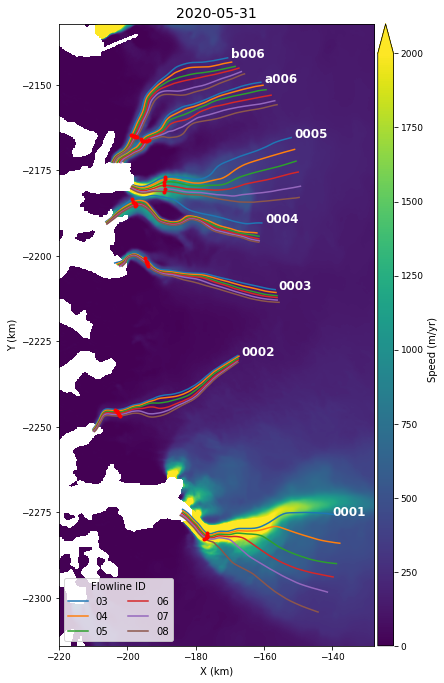

In [10]:
# set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6,12))
glacierPoints = {}
# generate a color dict that spans all flowline ids, using method from a flowline instance
flowlineColors = list(myFlowlines.values())[0].genColorDict(flowlineIDs=flowlineIDs)
# Messy plot stuff to get glacier labels in right place
xShift = {x: 1 for x in myFlowlines} # Dict index by glacier id
xShift['0001'] = -2 # custom for jakobshavn to keep on plot
# Display the velocity map for 2020 (note picks map nearest the date given). 
# Saturate color table at 2000 to maintain slower detail (vmax=2000)
myVelSeries.displayVelForDate('2020-01-01', ax=ax, labelFontSize=10, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=2000, units='km') 
# Look over each glacier and plot the flowlines
for glacierId in myFlowlines:
    # Plot the flowline Match units to the map
    myFlowlines[glacierId].plotFlowlineLocations(ax=ax, units='km', colorDict=flowlineColors)
    # 
    myFlowlines[glacierId].plotGlacierName(ax=ax, units='km', xShift=xShift[glacierId], 
                                           color='w', fontsize=12,fontweight='bold', first=False)
    # Generates points 10km
    points10km = myFlowlines[glacierId].extractPoints(10, None, units='km')
    glacierPoints[glacierId] = points10km
    for key in points10km:
        ax.plot(*points10km[key], 'r.')
# Create a dict of unique labels for legend
h, l = ax.get_legend_handles_labels()
by_label = dict(zip(l, h))
# Add legend
ax.legend(by_label.values(), by_label.keys(), title='Flowline ID', ncol=2)

## Plot Central Flowlines at Different Times

This example will demonstrate plotting the nominally central flowline ('06') for each of the six years for which there are currently data. This example works for annual data. Minor modifications are needed for the legend if more frequent data are selected above. 

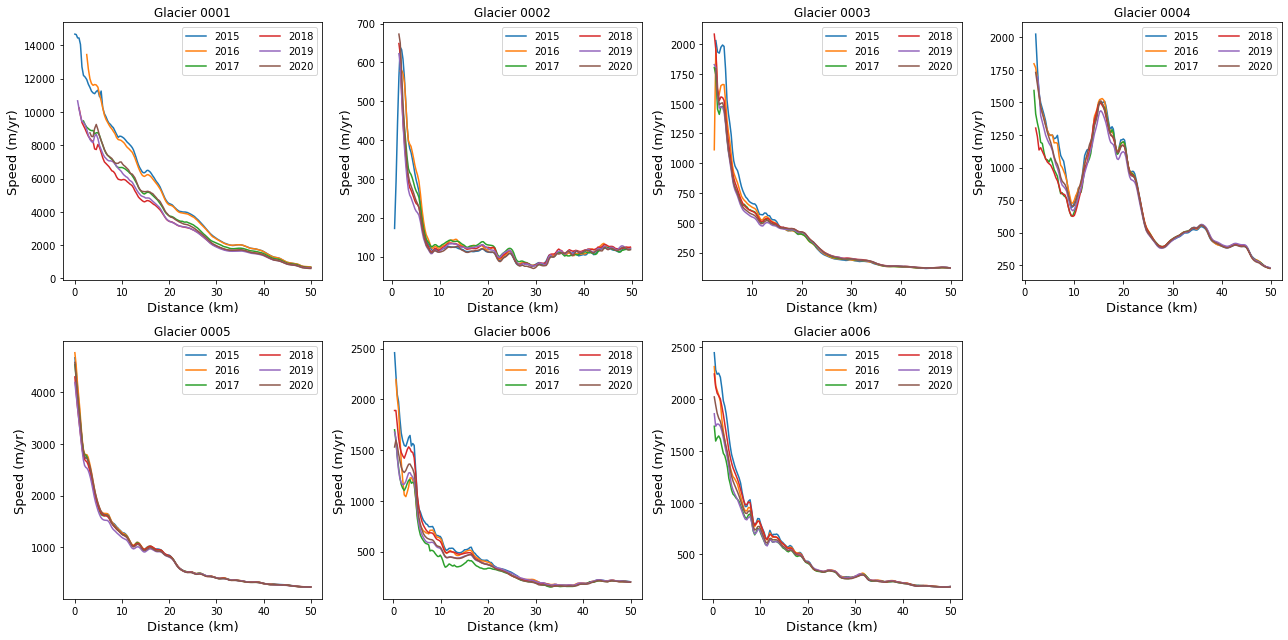

In [11]:
flowlineId ='06'  # Flowline id to plot
fig, axes = plt.subplots(np.ceil(len(myFlowlines)/4).astype(int), 4, figsize=(18, 9))  # Setup plot
# Loop over glaciers
for glacierId, ax in zip(myFlowlines, axes.flatten()):
    # return interpolated values as vx(time index, distance index)
    vx, vy, vv = myVelSeries.interp(*myFlowlines[glacierId].xykm(), units='km')
    # loop over each profile by time
    for speed, myDate in zip(vv, myVelSeries.time):
        ax.plot(myFlowlines[glacierId].distancekm(), speed, label=myDate.year)
    # pretty up plot
    ax.legend(ncol=2, loc='upper right')
    ax.set_xlabel('Distance (km)', fontsize=13)
    ax.set_ylabel('Speed (m/yr)', fontsize=13)
    ax.set_title(f'Glacier {glacierId}')
for ax in axes.flatten()[len(myFlowlines):]:
    ax.axis('off'); # kill axis with no plot
plt.tight_layout()

## Plot Points Through Time

This example plots the points extracted from 10 km along the flowine as a time series for each glacier.

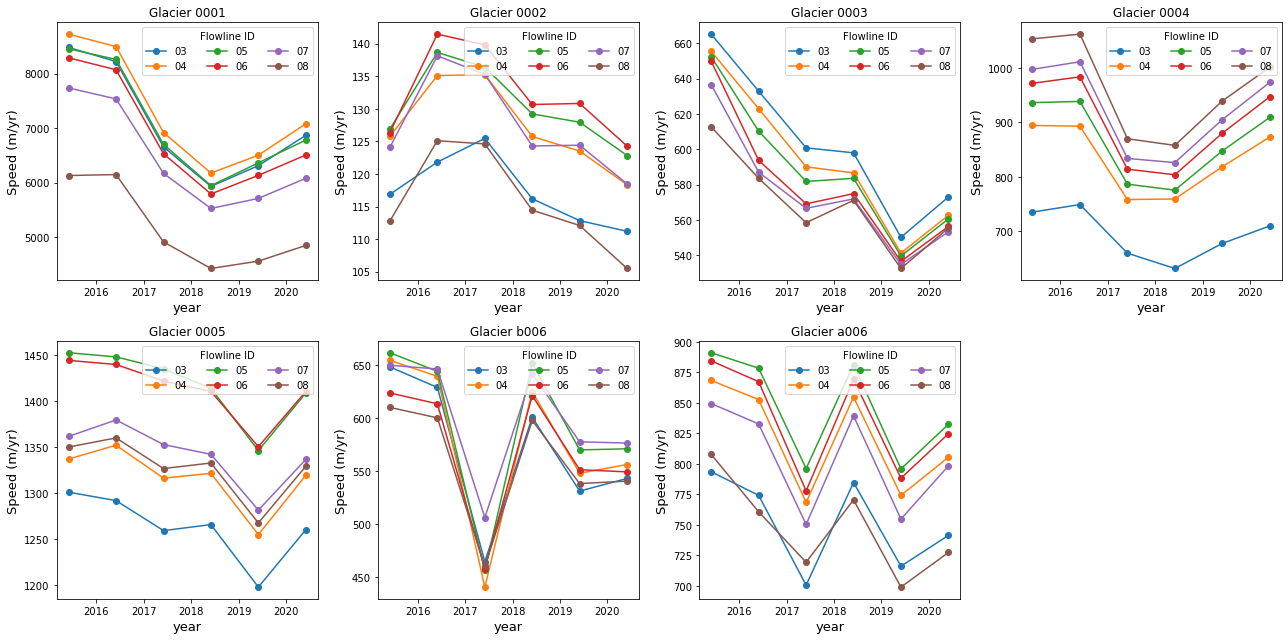

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# Loop over glaciers
for glacierId, ax in zip(glacierPoints, axes.flatten()):
    # Loop over flowlines
    for flowlineId in glacierPoints[glacierId]:
        # interpolate to get results vx(time index) for each point
        vx, vy, v = myVelSeries.interp(*glacierPoints[glacierId][flowlineId], units='km')
        ax.plot(myVelSeries.time, v, marker='o',  linestyle='-', color=flowlineColors[flowlineId],label=f'{flowlineId}')
    # pretty up plot
    ax.legend(ncol=3, loc='upper right', title='Flowline ID')
    ax.set_xlabel('year', fontsize=13)
    ax.set_ylabel('Speed (m/yr)', fontsize=13)
    ax.set_title(f'Glacier {glacierId}')
axes[-1, -1].axis('off'); # kill axis with no plot
plt.tight_layout()

# Visualizing with widgets

In [ ]:
# Dotson - requires a shapefile to plot that has been formated to lists of lat/lon pairs
# formatting for shapefile: Wcoords2 = [[Wlat2[i],Wlon2[i]] for i in range(Wlat2.shape[0])]

add

center = [-74.23, -112.00]
zoom = 8

mapdt1 = '2022-02-01'

global dc, start, end, file, lon_l, lat_l, lon_r, lat_r, dt

# Pick date
start = widgets.DatePicker(disabled=False)
end = widgets.DatePicker(disabled=False)
# dt = widgets.DatePicker(disabled=False)

# Select from map
draw_control = DrawControl(rectangle={}, polyline={'shapeOptions': {'color': '#fca45d','weight': 1,'opacity': 1.0}}, 
                 polygon={}, circlemarker={})

feature_collection = {
    'type': 'FeatureCollection',
    'features': []}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    feature_collection['features'].append(geo_json)

draw_control.on_draw(handle_draw)

m = Map(basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisAquaTrueColorCR, mapdt1),center=center,zoom=zoom)

line1 = Polyline(locations=Wcoords1, weight=1,color='red' , fill=False)
line2 = Polyline(locations=Wcoords2, weight=1,color='red' , fill=False)
m.add_layer(line1)
m.add_layer(line2)

# Provides drawing control - can add something that keeps what is drawn...
m.add_control(draw_control)

# Can upload a shapefile
file = widgets.FileUpload(accept='.shp', multiple=False)

# Specify a bounding box
lon_l = widgets.FloatText(description="lon")
lat_l = widgets.FloatText(description="lat")
lon_r = widgets.FloatText(description="lon")
lat_r = widgets.FloatText(description="lat")

AppLayout(header = VBox([HTML("<h1>Select area (time and space)</h1>"),
                 HBox([Label("Start Date:"), start, 
                       Label("End Date:"), end]),
                 # HBox([Label("Map Date:"), mapdt1])
                        ]),
             center = m,)

## Save the Data

The downloaded subset can be saved in a netcdf and reloaded for to `velSeries` instance for later analysis. Note if the data have been subsetted, the subset will be saved (~30MB in this example). If not, the entire Greeland data set will be saved (370GB). Change `saveData` and `reloadData` below to test this capability.

In [13]:
saveData = True # Set to True to save data
if saveData:
    myVelSeries.toNetCDF('Glaciers1-6example.nc')

In [14]:
reloadData = False  # Set to True to reload the saved data
if reloadData:
    myVelCDF = nisar.nisarVelSeries() # Create Series
    myVelCDF.readSeriesFromNetCDF('Glaciers1-6example.nc')
    #
    # repead above example with reloaded data
    #
    flowlineId ='06'  # Flowline id to plot
    fig, axes = plt.subplots(np.ceil(len(myFlowlines)/4).astype(int), 4, figsize=(18, 9))  # Setup plot
    # Loop over glaciers
    for glacierId, ax in zip(myFlowlines, axes.flatten()):
        # return interpolated values as vx(time index, distance index)
        vx, vy, vv = myVelCDF.interp(*myFlowlines[glacierId].xykm(), units='km')
        # loop over each profile by time
        for speed, myDate in zip(vv, myVelCDF.time):
            ax.plot(myFlowlines[glacierId].distancekm(), speed, label=myDate.year)
        # pretty up plot
        ax.legend(ncol=2, loc='upper right')
        ax.set_xlabel('Distance (km)', fontsize=13)
        ax.set_ylabel('Speed (m/yr)', fontsize=13)
        ax.set_title(f'Glacier {glacierId}')
    for ax in axes.flatten()[len(myFlowlines):]:
        ax.axis('off'); # kill axis with no plot
    plt.tight_layout()

## Summary

 🎉 Congratulations! You've completely this tutorial and have seen how we can add  notebook can be formatted, and how to create interactive map visualization with ipyleaflet.
 

```{note}
You may have noticed Jupyter Book adds some extra formatting features that do not necessarily render as you might expect when *executing* a noteook in Jupyter Lab. This "admonition" note is one such example.
```

:::{warning}
Jupyter Book is very particular about [Markdown header ordering](https://jupyterbook.org/structure/sections-headers.html?highlight=headers#how-headers-and-sections-map-onto-to-book-structure) to automatically create table of contents on the website. In this tutorial we are careful to use a single main header (#) and sequential subheaders (#, ##, ###, etc.)
:::

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [Jupyter Book rendering of .ipynb notebooks](https://jupyterbook.org/file-types/notebooks.html)
* [Jupyter Book guide on writing narrative content](https://jupyterbook.org/content/index.html)
* [ipyleaflet documentation](https://ipyleaflet.readthedocs.io)